#### **T2**: Thermal Insulation

This script uses the Fourier law of conduction

\begin{equation}
    q = -\lambda \nabla T
\end{equation}

to calculate the thermal conductivity $\lambda$ of different building materials.

To do this a steady-state method is utilised, where a materials of known and unknown conductivity are placed in series and a temperature gradient is placed across them. The unknown material $x$ has a thermal conductivity $\lambda_x$ by the equation:

\begin{equation}
    \lambda_R \frac{A_R}{d_R} \Delta T_R = \lambda_x \frac{A_x}{d_x} \Delta T_x.
\end{equation}

In [224]:
# import necessary libraries for data analysis
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

import pandas as pd
import sympy as sp
import os
import sys
from scipy.optimize import curve_fit

parent_dir = os.path.abspath("..")
sys.path.append(parent_dir)

from error_propagation import propagate_error_pd

In [225]:
# fits an exponential fit to thermocouple data to calculate equilibrium temperature
def get_equilibrium_temperature(t, T, T_err):
    def func(t, A, B, beta): # exponential fit from Newton's law of cooling
        return A + B*np.exp(-t * beta)

    # add initial guesses
    p0 = [T.iloc[-1], T.iloc[0] - T.iloc[-1], 0.01]

    popt, pcov = curve_fit(func, t, T, sigma=T_err, p0 = p0)

    errs = np.sqrt(np.diag(pcov))

    return popt, errs 

In [226]:
def get_thermal_conductivity( # takes variables from equation 2 and calculates l_x (thermal conductivity of x)
    A_r, 
    A_r_err,
    A_x,
    A_x_err,
    d_r,
    d_r_err,
    d_x,
    d_x_err,
    l_r,
    l_r_err,
    T_1,
    T_1_err,
    T_2,
    T_2_err,
    T_3,
    T_3_err,
    T_4,
    T_4_err,
):
    # calculates value and propagates error
    a1, a2, d1, d2, l1, t1, t2, t3, t4 = sp.symbols('A_r, A_x, d_r, d_x, l_r, T_1, T_2, T_3, T_4')

    l2 = l1 * a1/d1 * d2/a2 * (t2-t1) / (t4 - t3)

    vars = {
        a1: (A_r, A_r_err),
        a2: (A_x, A_x_err),
        d1 : (d_r, d_r_err),
        d2: (d_x, d_x_err),
        l1: (l_r, l_r_err),
        t1: (T_1, T_1_err),
        t2: (T_2, T_2_err),
        t3: (T_3, T_3_err),
        t4: (T_4, T_4_err)
    }

    return propagate_error_pd(l2, vars)

In [227]:
def plot_temperature_data(t, T, marker_color, label):
    # plot experimental data
    plt.plot(
        t, T, '.', label=label,
        color=marker_color,
        markersize=3)
        
def plot_temperature_fits(t, coeffs, line_color, label):
    # plot fit data
    fine_t = np.linspace(min(t), max(t), 1000)
    
    plt.plot(
        fine_t, coeffs[0] + coeffs[1] * np.exp(-fine_t * coeffs[2]),
        color=line_color, label=label
        )

In [228]:
def process_experimental_data(
    data,
    l_r,
    l_r_err,
    A_r,
    A_r_err,
    A_x,
    A_x_err,
    d_r,
    d_r_err,
    d_x,
    d_x_err,
    material
):
    coeffs_1, errs_1 = get_equilibrium_temperature(data['t'], data['T_1'], 0.001)
    coeffs_2, errs_2 = get_equilibrium_temperature(data['t'], data['T_2'], 0.001)
    coeffs_3, errs_3 = get_equilibrium_temperature(data['t'], data['T_3'], 0.001)
    coeffs_4, errs_4 = get_equilibrium_temperature(data['t'], data['T_4'], 0.001)

    l_x, l_x_err = get_thermal_conductivity(
        A_r, A_r_err, A_x, A_x_err, d_r, d_r_err, d_x, d_x_err, l_r, l_r_err, coeffs_1[0], errs_1[0], coeffs_2[0], errs_2[0], coeffs_3[0], errs_3[0], coeffs_4[0], errs_4[0]
    )

    # plot t1, t2 and t3 data

    # plot data
    data_fig = plt.figure()

    plot_temperature_data(
        data['t'],
        data['T_1'],
        '#1f77b4',
        'Reference Cold Side'
    )

    plot_temperature_data(
        data['t'],
        data['T_2'],
        '#ff7f0e',
        'Reference Hot Side'
    )

    plot_temperature_data(
        data['t'],
        data['T_3'],
        '#2ca02c',
        f'{material} Cold Side'
    )

    plot_temperature_data(
        data['t'],
        data['T_4'],
        "#f122cf",
        f'{material} Hot Side'
    )

    plt.legend(frameon=True, loc=(0.7, 0.65), fontsize='small', fancybox=False, framealpha=0.95, edgecolor="#000000AC")

    plt.xlabel('Time /s')
    plt.ylabel('Temperature /°C')

    plt.tight_layout()

    data_fig.savefig(f'{material.lower()}-data.png', dpi=300)

    #plot fits
    fit_fig = plt.figure()

    plot_temperature_fits(
        data['t'],
        coeffs_1,
        '#1f77b4',
        'Reference Cold Side'
    )

    plot_temperature_fits(
        data['t'],
        coeffs_2,
        '#ff7f0e',
        'Reference Hot Side'
    )

    plot_temperature_fits(
        data['t'],
        coeffs_3,
        '#2ca02c',
        f'{material} Cold Side'
    )

    plot_temperature_fits(
        data['t'],
        coeffs_4,
        "#f122cf",
        f'{material} Hot Side'
    )

    plt.legend(frameon=True, loc=(0.7, 0.65), fontsize='small', fancybox=False, framealpha=0.95, edgecolor="#000000AC")

    plt.xlabel('Time /s')
    plt.ylabel('Temperature /°C')

    plt.tight_layout()

    fit_fig.savefig(f'{material.lower()}-fits.png', dpi=300)
    
    # print results
    print(f"T1 = {coeffs_1[0]:.3f}±{errs_1[0]:.3f} °C")
    print(f"T2 = {coeffs_2[0]:.3f}±{errs_2[0]:.3f} °C")
    print(f"T3 = {coeffs_3[0]:.3f}±{errs_3[0]:.3f} °C")
    print(f"T4 = {coeffs_4[0]:.3f}±{errs_4[0]:.3f} °C")
    print(f"delta_T_r = {coeffs_2[0] - coeffs_1[0]:.3f}±{np.sqrt(errs_2[0]**2 + errs_1[0]**2):.3f}")
    print(f"delta_T_x = {coeffs_4[0] - coeffs_3[0]:.3f}±{np.sqrt(errs_4[0]**2 + errs_3[0]**2):.3f}")
    print(f"l_x = {l_x:.5f}±{l_x_err:.5f}")

T1 = 5.013±0.001 °C
T2 = 14.049±0.002 °C
T3 = 16.632±0.001 °C
T4 = 26.332±0.001 °C
delta_T_r = 9.036±0.002
delta_T_x = 9.700±0.002
l_x = 0.14591±0.00022


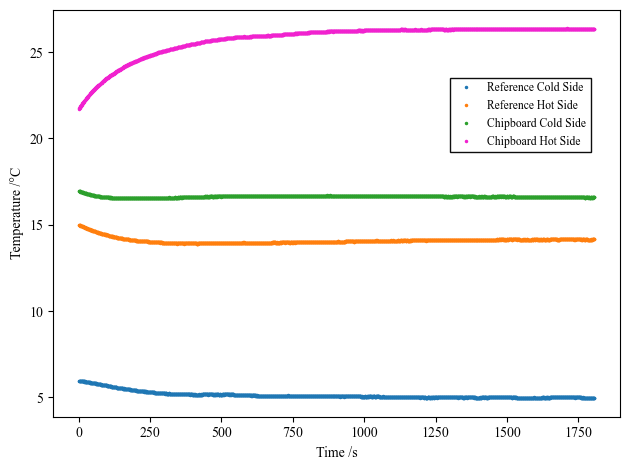

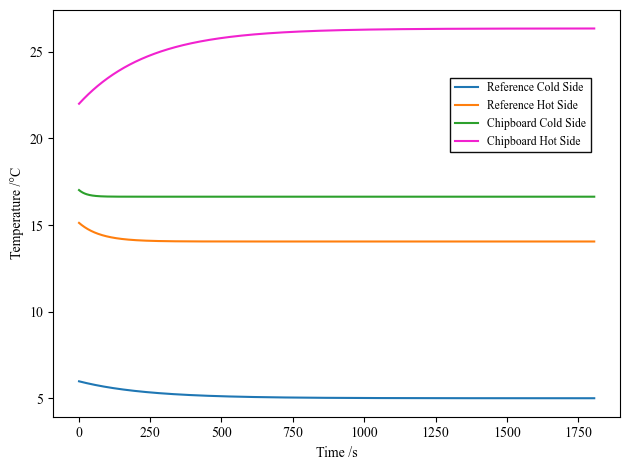

In [229]:
run = pd.read_csv("chipboard-20-11-2025-1.csv")

process_experimental_data(
    run,
    0.17, # l_r
    0, # l_r_err
    0.022313, # A_r
    0.000010, # A_r_err
    0.022538, # A_x
    0.000010, # A_x_err
    0.01081, # d_r
    0.00001, # d_r_err
    0.01006, # d_x
    0.00001, # d_x_err
    'Chipboard' # material name for labels & filenames
)

T1 = 4.380±0.002 °C
T2 = 7.443±0.015 °C
T3 = 7.457±0.107 °C
T4 = 31.465±0.001 °C
delta_T_r = 3.063±0.015
delta_T_x = 24.009±0.107
l_x = 0.02193±0.00015


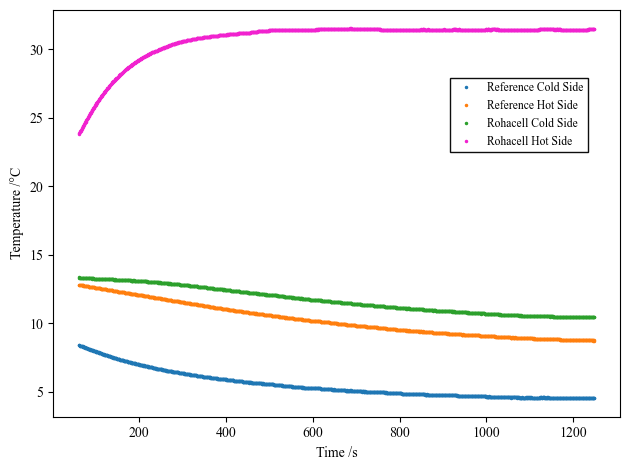

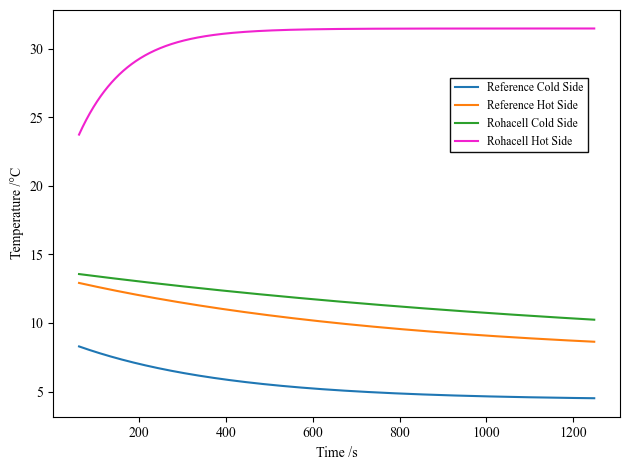

In [230]:
run = pd.read_csv("rohacell-20-11-2025-1.csv")

# mask and swap columns so consistent with calcs
run = run[run['t'] > 60]
run = run[run['t'] < 1250]

temp3 = run['T_3']
temp4 = run['T_4']

run['T_3'] = temp4
run['T_4'] = temp3

process_experimental_data(
    run,
    0.17, # l_r
    0, # l_r_err
    0.022313, # A_r
    0.000010, # A_r_err
    0.022395, # A_x
    0.000010, # A_x_err
    0.01081, # d_r
    0.00001, # d_r_err
    0.01097, # d_x
    0.00001, # d_x_err
    'Rohacell' # material name for labels & filenames
)

T1 = 4.634±0.004 °C
T2 = 10.181±0.006 °C
T3 = 12.559±0.014 °C
T4 = 39.924±0.012 °C
delta_T_r = 5.547±0.007
delta_T_x = 27.365±0.018
l_x = 0.03484±0.00006


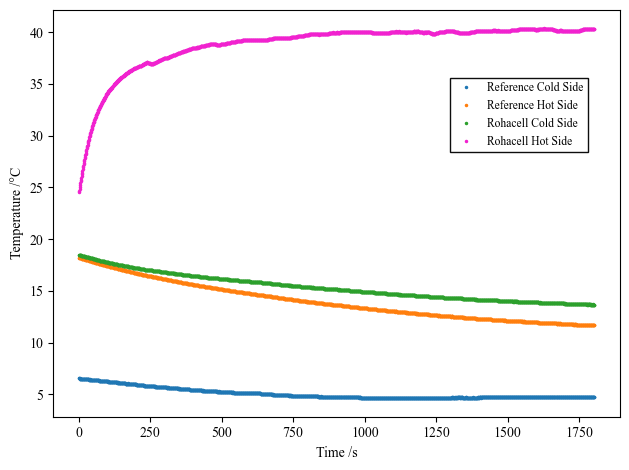

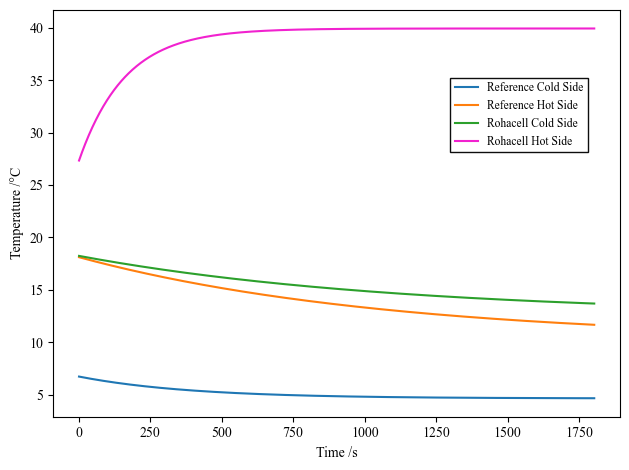

In [231]:
run = pd.read_csv("rohacell-20-11-2025-2.csv")

process_experimental_data(
    run,
    0.17, # l_r
    0, # l_r_err
    0.022313, # A_r
    0.000010, # A_r_err
    0.022395, # A_x
    0.000010, # A_x_err
    2*0.01081, # d_r
    0.00001, # d_r_err
    2*0.01097, # d_x
    0.00001, # d_x_err
    'Rohacell' # material name for labels & filenames
)

T1 = 19.105±0.293 °C
T2 = 20.549±0.030 °C
T3 = 20.299±0.001 °C
T4 = 25.987±0.001 °C
delta_T_r = 1.444±0.295
delta_T_x = 5.688±0.001
l_x = 0.01990±0.00406


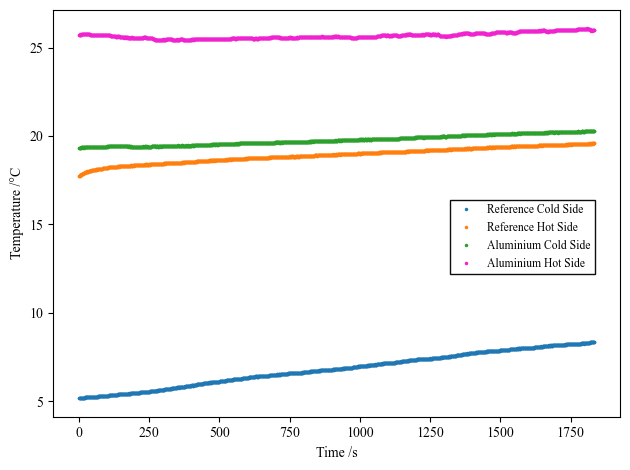

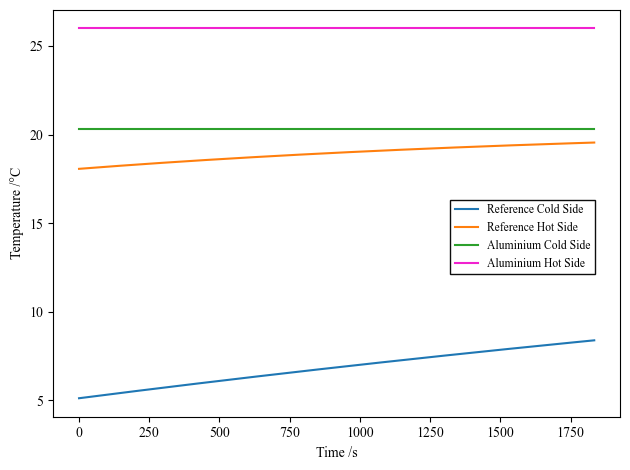

In [249]:
data = pd.read_csv("aluminium-20-11-2025-1.csv")

coeffs_1, errs_1 = get_equilibrium_temperature(data['t'], data['T_1'], 0.001)
coeffs_2, errs_2 = get_equilibrium_temperature(data['t'], data['T_2'], 0.001)

# as data is mostly linear for T4 and T3 additional analysis required
coeffs_3 = [data['T_3'].iloc[-1]]
errs_3 = [0.001]
coeffs_4 = [data['T_4'].iloc[-1]]
errs_4 = [0.001]
material = 'Aluminium'

l_x, l_x_err = get_thermal_conductivity(
    0.022313, 0.000010, 0.022545, 0.000010, 2*0.01081, 0.00001, 0.01007, 0.00001, 0.17, 0, coeffs_1[0], errs_1[0], coeffs_2[0], errs_2[0], coeffs_3[0], errs_3[0], coeffs_4[0], errs_4[0]
)

# plot t1, t2 and t3 data

# plot data
data_fig = plt.figure()

plot_temperature_data(
    data['t'],
    data['T_1'],
    '#1f77b4',
    'Reference Cold Side'
)

plot_temperature_data(
    data['t'],
    data['T_2'],
    '#ff7f0e',
    'Reference Hot Side'
)

plot_temperature_data(
    data['t'],
    data['T_3'],
    '#2ca02c',
    f'{material} Cold Side'
)

plot_temperature_data(
    data['t'],
    data['T_4'],
    "#f122cf",
    f'{material} Hot Side'
)

plt.legend(frameon=True, loc=(0.7, 0.35), fontsize='small', fancybox=False, framealpha=0.95, edgecolor="#000000AC")

plt.xlabel('Time /s')
plt.ylabel('Temperature /°C')

plt.tight_layout()

data_fig.savefig(f'{material.lower()}-data.png', dpi=300)

#plot fits
fit_fig = plt.figure()

plot_temperature_fits(
    data['t'],
    coeffs_1,
    '#1f77b4',
    'Reference Cold Side'
)

plot_temperature_fits(
    data['t'],
    coeffs_2,
    '#ff7f0e',
    'Reference Hot Side'
)

# plot fit data
fine_t = np.linspace(min(data['t']), max(data['t']), 1000)

plt.plot(
    fine_t, np.polyval(coeffs_3, fine_t),
    color='#2ca02c', label=f'{material} Cold Side'
)

plt.plot(
    fine_t, np.polyval(coeffs_4, fine_t),
    color='#f122cf', label=f'{material} Hot Side'
)

plt.legend(frameon=True, loc=(0.7, 0.35), fontsize='small', fancybox=False, framealpha=0.95, edgecolor="#000000AC")

plt.xlabel('Time /s')
plt.ylabel('Temperature /°C')

plt.tight_layout()

fit_fig.savefig(f'{material.lower()}-fits.png', dpi=300)

# print results
print(f"T1 = {coeffs_1[0]:.3f}±{errs_1[0]:.3f} °C")
print(f"T2 = {coeffs_2[0]:.3f}±{errs_2[0]:.3f} °C")
print(f"T3 = {coeffs_3[0]:.3f}±{errs_3[0]:.3f} °C")
print(f"T4 = {coeffs_4[0]:.3f}±{errs_4[0]:.3f} °C")
print(f"delta_T_r = {coeffs_2[0] - coeffs_1[0]:.3f}±{np.sqrt(errs_2[0]**2 + errs_1[0]**2):.3f}")
print(f"delta_T_x = {coeffs_4[0] - coeffs_3[0]:.3f}±{np.sqrt(errs_4[0]**2 + errs_3[0]**2):.3f}")
print(f"l_x = {l_x:.5f}±{l_x_err:.5f}")